In [1]:
import sys
sys.path.append('/home/jhernandez/Work//')
sys.path.append('/home/jhernandez/Work/python_tools/')

from defaults import *
from tqdm import tqdm
import pyroms
import seawater as sw

# **EuroSea WP2 OSSE. Impact on T & S fields**

## Calculate RMSD against CTD Observations

    Comparison are made against pseudo-obs provided by CSIC - IMEDEA

**Load fields**

In [2]:
file_obs = '/mnt/vinson/DATA/jhernandez/WMOP_ASSIM/Observations/EuroSea_OSSE/obsfile_CTD_pseudo_enatl60_20090904.obs'
file_ctd = '/LOCALDATA/Data/EuroSea_WP2/eNATL60_pseudo-obs/Med_conf_r_dep_1000m_res_10km_Sep_eNATL60.nc'

In [3]:
# Load obsfile
df_obs = tools.read_obsfile(file_obs)


In [4]:
date = datetime(2009,9,5)

file_wmop = glob(F"/home/modelling/data/WMOP/WMOP_HINDCAST/Outputs/HINDCAST_MFS_v17/{date.strftime('%Y/%m/%d')}/*avg.nc")[0]
ds_wmop = xr.open_dataset(file_wmop)

**Load grid**

In [7]:
grd = pyroms.grid.get_ROMS_grid('grid', hist_file=file_wmop, grid_file=file_wmop)
zeta = grd.vgrid.z_r[:]

Assuming spherical is integer b'T' <class 'numpy.ma.core.MaskedArray'>
Load geographical grid from file


### Interpolate WMOP fields to Observation points

In [243]:
from scipy.interpolate import interp1d

# get Lon Lat of CTD casts
lonlat_obs = df_obs[['lon', 'lat']].drop_duplicates()

date = datetime(2009,9,5)

experiments = ['CR', 'CTD', 'SLA-v1_SST_Argo', 'SLA-v1_SST_Argo_CTD-v3', 'SLA-v1_SST_Argo_CTD-v4']

rmsd_temp = {}
rmsd_salt = {}

for exp in tqdm(experiments):
    
    if exp == 'CR':
        file_wmop = glob(F"/home/modelling/data/WMOP/WMOP_HINDCAST/Outputs/HINDCAST_MFS_v17/{date.strftime('%Y/%m/%d')}/*avg.nc")[0]
    else:
        path_da = '/mnt/vinson/DATA/jhernandez/ROMS/Outputs/EuroSea_OSSE_nudging/'
        file_wmop = F"{path_da}{exp}/roms_WMOP_ASSIM_{date.strftime('%Y%m%d')}_avg.nc"
        
    ds_wmop = xr.open_dataset(file_wmop)

    for i in range(lonlat_obs.shape[0]):

        # Get Lon Lat of specific profile
        lon0 = lonlat_obs.iloc[i]['lon']
        lat0 = lonlat_obs.iloc[i]['lat']


        nlon = np.argmin(np.abs(ds_wmop.lon_rho[0,:].values - lon0))
        nlat = np.argmin(np.abs(ds_wmop.lat_rho[:,0].values - lat0))

        z0 = zeta[:,nlat,nlon]

        # Get profile values of Observations
        df_prof_t = df_obs[(df_obs.lon == lon0) & (df_obs.lat == lat0) & (df_obs['var'] == 't')]
        df_prof_s = df_obs[(df_obs.lon == lon0) & (df_obs.lat == lat0) & (df_obs['var'] == 's')]

        # If Obs have values lower than roms --> substitute
        z_obs = df_prof_t['depth'].values[::-1].copy()
        z_roms = -z0
        if  z_obs.max() > z_roms.max():
            z_obs[0] = z_roms[0]

        # Interpolate
        f = interp1d(z_roms, ds_wmop.temp[0,:,nlat,nlon].values)
        t_interp = f(z_obs)

        f = interp1d(z_roms, ds_wmop.salt[0,:,nlat,nlon].values)
        s_interp = f(z_obs)


        df_prof_t['val_wmop'] = t_interp[::-1]
        df_prof_s['val_wmop'] = s_interp[::-1]

        if i==0:

            df_all_interp = pd.concat([df_prof_t, df_prof_s]).reset_index(drop=True)

        else:
            df_all_interp = pd.concat([df_all_interp, df_prof_t, df_prof_s]).reset_index(drop=True)
    
    ii = df_all_interp['var'] == 't'
    rmsd_temp[exp] = np.sqrt( np.nanmean( (df_all_interp['val'][ii] - df_all_interp['val_wmop'][ii])**2 ) )

    ii = df_all_interp['var'] == 's'
    rmsd_salt[exp] = np.sqrt( np.nanmean( (df_all_interp['val'][ii] - df_all_interp['val_wmop'][ii])**2 ) )

100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


### **Create RMSD Dataframe and Plot**

In [8]:
df_rmsd = pd.DataFrame(data=[rmsd_temp, rmsd_salt], index=['CTD Temp', 'CTD Salt'])
df_rmsd = df_rmsd.rename(columns={'CR': 'CR', 'CTD': 'CTD', 'SLA-v1_SST_Argo': 'SLA+SST+Argo', 'SLA-v1_SST_Argo_CTD-v3': 'SLA+SST+Argo+CTD',
                        'SLA-v1_SST_Argo_CTD-v4': 'SLA+SST+Argo+CTD(>15m)'})
# df_rmsd.plot.bar(figsize=(7,4))

In [9]:
df_rmsd_norm = df_rmsd.copy(deep=True)
df_rmsd_norm.T['CTD Temp'] = df_rmsd_norm.T['CTD Temp'] / df_rmsd.T['CTD Temp'].loc['CR']
df_rmsd_norm.T['CTD Salt'] = df_rmsd_norm.T['CTD Salt'] / df_rmsd.T['CTD Salt'].loc['CR']

In [10]:
df_rmsd_norm.T

CTD Temp  CTD Salt
CR                      1.000000  1.000000
CTD                     0.575864  0.530472
SLA+SST+Argo            0.843629  0.841145
SLA+SST+Argo+CTD        0.567089  0.492083
SLA+SST+Argo+CTD(>15m)  0.556118  0.530583

Text(0.5, 1.0, 'Normalized RMSD for CTD Profiles')

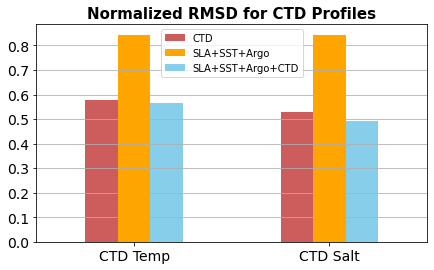

In [12]:
# Barplot of RMSD
ax = df_rmsd_norm[['CTD', 'SLA+SST+Argo', 'SLA+SST+Argo+CTD']].plot.bar(rot=0, figsize=(7,4),  color=['indianred','orange','skyblue'], fontsize=14)
fig = ax.get_figure()
ax.grid(axis='y')
ax.set_title('Normalized RMSD for CTD Profiles', fontsize=15, fontweight='bold')

In [229]:
import os

plot_path = '/home/jhernandez/Escritorio/Plots_validation_OSSE_pre-SWOT/'
if os.path.exists(plot_path) == False:
    os.mkdir(plot_path)
    
fig.savefig(F"{plot_path}/rmsd_ctds-v2.png", 
            dpi=250, transparent=False, facecolor="w")

## Calculate  RMSD against NR fields 

    Interpolate NR and WMOP to same lonlat
    
    1- Define lon lats
    2- Interp WMOP
    3 -Interp NR

### Define Grid to Interpolate

In [2]:
from scipy.interpolate import griddata
from scipy import interpolate
from scipy.interpolate import interp1d


In [3]:
limits = [1.35, 2.49, 39.7, 40.5]
#limits = [-5, 9, 37, 43.5]

In [8]:
nx = 40
ny = 40
lons_interp = np.linspace(limits[0], limits[1], nx)
lats_interp = np.linspace(limits[2], limits[3], ny)

#z_interp = [5, 10, 15, 20, 25, 30, 40, 50, 70, 100, 125, 150, 175, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]
# z_interp = [5, 10, 15, 20, 25, 30, 40, 50, 70, 100, 125, 150, 175, 200, 250, 300, 400, 500, 600, 700, 800]
z_interp = np.linspace(0, 800, 100)

**Check grid resolution**

In [9]:
import geopy.distance

coords_1 = (lons_interp[0], lats_interp[0])
coords_2 = (lons_interp[1], lats_interp[0])

geopy.distance.geodesic(coords_1, coords_2)

Distance(3.232189547449431)

### **Interpolate WMOP simulations to regular 3d grid**

In [10]:
# Create dictionary for Interpolated values
t_interp = {}
s_interp = {}

date = datetime(2009,9,5)

experiments = ['CR', 'CTD', 'SLA-v1_SST_Argo', 'SLA-v1_SST_Argo_CTD-v3', 'SLA-v1_SST_Argo_CTD-v4']

rmsd_temp = {}
rmsd_salt = {}

for exp in tqdm(experiments):
    
    if exp == 'CR':
        file_wmop = glob(F"/home/modelling/data/WMOP/WMOP_HINDCAST/Outputs/HINDCAST_MFS_v17/{date.strftime('%Y/%m/%d')}/*avg.nc")[0]
    else:
        path_da = '/mnt/vinson/DATA/jhernandez/ROMS/Outputs/EuroSea_OSSE_nudging/'
        file_wmop = F"{path_da}{exp}/roms_WMOP_ASSIM_{date.strftime('%Y%m%d')}_avg.nc"
        
    ds_wmop = xr.open_dataset(file_wmop)
    
    t_interp[exp] = np.empty((len(z_interp), ny, nx))
    s_interp[exp] = np.empty((len(z_interp), ny, nx))
    
    # Interpolation
    for i in range(len(lons_interp)):
        for j in range(len(lats_interp)):


            nlon = np.argmin(np.abs(ds_wmop.lon_rho[0,:].values - lons_interp[i]))
            nlat = np.argmin(np.abs(ds_wmop.lat_rho[:,0].values - lats_interp[j]))

            z0 = zeta[:,nlat,nlon]
            z_roms = -z0

            nzlim = np.argmin(np.abs(z_roms.max() - z_interp))
            
            # Interpolate Temp
            f = interp1d(z_roms, ds_wmop.temp[0,:,nlat,nlon].values, fill_value="extrapolate")
            t_interp[exp][:,j,i] = f(z_interp)
#             t_interp[exp][nzlim:,j,i] = np.nan        
                        
            # Interpolate Salt
            f = interp1d(z_roms, ds_wmop.salt[0,:,nlat,nlon].values, fill_value="extrapolate")
            s_interp[exp][:,j,i] = f(z_interp)
#             s_interp[exp][nzlim:,j,i] = np.nan

100%|██████████| 5/5 [00:28<00:00,  5.73s/it]


### **Interpolate NR to same regular 3d grid**

    1 - Griddata at each vertical level in 2D
    2 - Interp in vertical

**Load NATL60 fields**

In [11]:
file_temp = '/LOCALDATA/Data/eNATL60/WMED_3D-fields/eNATL60MEDWEST-BLB002_y2009m09d05.1h_votemper.nc'
file_salt = F"/LOCALDATA/Data/eNATL60/WMED_3D-fields/eNATL60MEDWEST-BLB002_y{date.strftime('%Ym%md%d')}.1h_vosaline.nc"

ds_temp = xr.open_dataset(file_temp)
ds_salt = xr.open_dataset(file_salt)

mask_natl = xr.open_dataset('/LOCALDATA/Data/eNATL60/mask_eNATL60MEDWEST_3.6.nc')

In [12]:
from scipy.interpolate import griddata
from scipy import interpolate

# Meshgrid Lon, Lat from MDT
xx, yy = np.meshgrid(lons_interp, lats_interp)
xx = xx.flatten()
yy = yy.flatten()

# Set grid Lon, Lat from MDT as tuple of arrays
lonlat = np.array([xx,yy]).T

natl_grid_temp = np.empty((ds_temp.votemper.shape[1], ny, nx))
natl_grid_salt = np.empty((ds_salt.vosaline.shape[1], ny, nx))


**Griddata at each vertical level in 2D**

In [13]:
# Set Irregular grid Lon, Lat from SSH as tuple of arrays
points = np.array([mask_natl.nav_lon.values.flatten(), mask_natl.nav_lat.values.flatten()]).T

# Griddata to regular GRID for each depth
for i in tqdm(range(ds_temp.votemper.shape[1])):
    # Set SSH values as array
    values_temp = ds_temp.votemper[0,i,:,:].values.flatten()
    values_salt = ds_salt.vosaline[0,i,:,:].values.flatten()

    # Interpolate Temp and reshape into regular grid
    natl_interp = griddata(points, values_temp, lonlat, method='nearest')
    natl_grid_temp[i,:,:] = np.reshape(natl_interp, (nx,ny))
    
    # Interpolate Temp and reshape into regular grid
    natl_interp = griddata(points, values_salt, lonlat, method='nearest')
    natl_grid_salt[i,:,:] = np.reshape(natl_interp, (nx,ny))

natl_grid_temp[natl_grid_temp<10] = np.nan
natl_grid_salt[natl_grid_salt<35] = np.nan

100%|██████████| 300/300 [05:16<00:00,  1.05s/it]


**Interpolate in vertical to defined depth**

In [14]:
# Interpolate in depth
t_interp['NR'] = np.empty((len(z_interp), ny, nx))
s_interp['NR'] = np.empty((len(z_interp), ny, nx))

# Interpolation
for i in range(len(lons_interp)):
    for j in range(len(lats_interp)):
        
        nzlim = np.argmin(np.abs(ds_temp.deptht.values.max() - z_interp))
        
        f = interp1d(ds_temp.deptht.values, natl_grid_temp[:,j,i], fill_value="extrapolate")
        t_interp['NR'][:,j,i] = f(z_interp)
#         t_interp['NR'][nzlim:,j,i] = np.nan 
        
        f = interp1d(ds_salt.deptht.values, natl_grid_salt[:,j,i], fill_value="extrapolate")
        s_interp['NR'][:,j,i] = f(z_interp)
#         s_interp['NR'][nzlim:,j,i] = np.nan 
        
t_interp['NR'][t_interp['NR']<10] = np.nan
s_interp['NR'][s_interp['NR']<35] = np.nan

**Calculate Metrics**

In [17]:
mse_temp_prof = {}; mse_salt_prof = {}; mse_dens_prof = {}
mse_temp = {}; mse_salt = {}; mse_dens = {}

bias_temp_prof = {}; bias_salt_prof = {}; bias_dens_prof = {}
bias_temp = {}; bias_salt = {}; bias_dens = {}
ccoef_temp = {}; ccoef_salt = {}; ccoef_dens = {}

t_interp['NR'][t_interp['NR']<10] = np.nan
s_interp['NR'][s_interp['NR']<35] = np.nan

z_matrix = np.tile(z_interp, (40,40,1) ).T
d_interp = {}
d_interp['NR'] = sw.dens(s_interp['NR'], t_interp['NR'], z_matrix*0)

for exp in tqdm(experiments):
    
    t_interp[exp][t_interp[exp]<10] = np.nan
    s_interp[exp][s_interp[exp]<35] = np.nan
    d_interp[exp] = sw.dens(s_interp[exp], t_interp[exp], z_matrix*0)

    
    mse_temp_prof[exp] = np.sqrt( np.nanmean(np.nanmean( (t_interp['NR'] - t_interp[exp])**2, axis=1 ), axis=1) )
    mse_temp[exp] = np.sqrt( np.nanmean( (t_interp['NR'] - t_interp[exp])**2 ) )
#     bias_temp[exp] = np.nanmean(t_interp['NR']) - np.nanmean(t_interp[exp])
#     bias_temp_prof[exp] = np.nanmean(np.nanmean(t_interp['NR'], axis=1 ), axis=1) - np.nanmean(np.nanmean(t_interp[exp], axis=1), axis=1) 
    bias_temp[exp] = np.nanmean(t_interp['NR'] - t_interp[exp])
    bias_temp_prof[exp] = np.nanmean(np.nanmean(t_interp['NR'] - t_interp[exp], axis=1), axis=1) 
   
    
    mse_salt_prof[exp] = np.sqrt( np.nanmean(np.nanmean( (s_interp['NR'] - s_interp[exp])**2, axis=1 ), axis=1) )
    mse_salt[exp] = np.sqrt( np.nanmean( (s_interp['NR'] - s_interp[exp])**2 ) )
#     bias_salt[exp] = np.nanmean(s_interp['NR']) - np.nanmean(s_interp[exp])
#     bias_salt_prof[exp] = np.nanmean(np.nanmean(s_interp['NR'], axis=1 ), axis=1 ) - np.nanmean(np.nanmean(s_interp[exp], axis=1), axis=1) 
    bias_salt[exp] = np.nanmean(s_interp['NR'] - s_interp[exp])
    bias_salt_prof[exp] = np.nanmean(np.nanmean(s_interp['NR'] - s_interp[exp], axis=1), axis=1) 
    
    mse_dens_prof[exp] = np.sqrt( np.nanmean(np.nanmean( (d_interp['NR'] - d_interp[exp])**2, axis=1 ), axis=1) )
    mse_dens[exp] = np.sqrt( np.nanmean( (d_interp['NR'] - d_interp[exp])**2 ) )
#     bias_dens[exp] = np.nanmean(d_interp['NR']) - np.nanmean(d_interp[exp])
#     bias_dens_prof[exp] = np.nanmean(np.nanmean(d_interp['NR'], axis=1 ), axis=1 ) - np.nanmean(np.nanmean(d_interp[exp], axis=1), axis=1) 
    bias_dens[exp] = np.nanmean(d_interp['NR'] - d_interp[exp])
    bias_dens_prof[exp] = np.nanmean(np.nanmean(d_interp['NR'] - d_interp[exp], axis=1), axis=1) 
    
    kt = ~np.isnan(t_interp['NR'].flatten()) & ~np.isnan(t_interp[exp].flatten())
    ks = ~np.isnan(s_interp['NR'].flatten()) & ~np.isnan(s_interp[exp].flatten())
    ccoef_temp[exp] = np.corrcoef(t_interp['NR'].flatten()[kt], t_interp[exp].flatten()[kt])[0][1]
    ccoef_salt[exp] = np.corrcoef(s_interp['NR'].flatten()[ks], s_interp[exp].flatten()[ks])[0][1]
    ccoef_dens[exp] = np.corrcoef(d_interp['NR'].flatten()[ks], d_interp[exp].flatten()[ks])[0][1]
    
plt.show()

100%|██████████| 5/5 [00:00<00:00, 30.57it/s]


**Plot Temp and Salinity profiles**

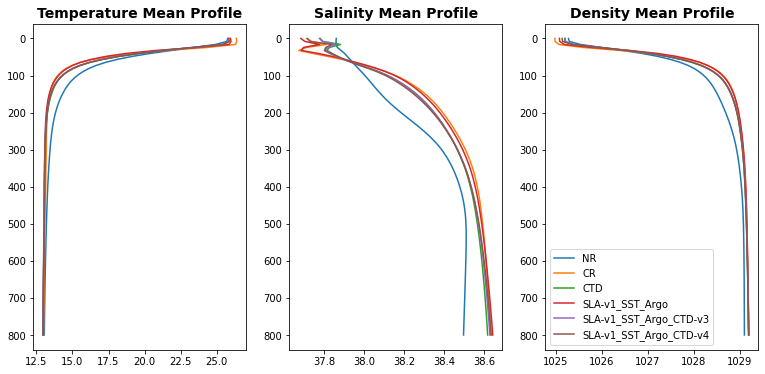

In [18]:
fig_prof = plt.figure(figsize=(13,6))
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)
ax1.plot(np.nanmean(np.nanmean(t_interp['NR'], axis=1), axis=1), z_interp, label='NR')
ax2.plot(np.nanmean(np.nanmean(s_interp['NR'], axis=1), axis=1), z_interp, label='NR')
ax3.plot(np.nanmean(np.nanmean(d_interp['NR'], axis=1), axis=1), z_interp, label='NR')

for exp in experiments:
    
    ax1.plot(np.nanmean(np.nanmean(t_interp[exp] , axis=1), axis=1), z_interp, label=exp)
#     ax1.set_ylim((0,200))
#     ax1.set_xlim((0,0.8))
    ax1.invert_yaxis()
    ax1.set_title('Temperature Mean Profile', fontsize=14, fontweight='bold')
    
    
    ax2.plot(np.nanmean(np.nanmean(s_interp[exp], axis=1), axis=1), z_interp, label=exp)
#     ax2.set_ylim((0, 200))
    ax2.invert_yaxis()
#     ax2.legend()
    ax2.set_title('Salinity Mean Profile', fontsize=14, fontweight='bold')
    
    ax3.plot(np.nanmean(np.nanmean(d_interp[exp], axis=1), axis=1), z_interp, label=exp)
#     ax2.set_ylim((0, 200))
    ax3.invert_yaxis()
    ax3.legend()
    ax3.set_title('Density Mean Profile', fontsize=14, fontweight='bold')
    

plt.show()

In [654]:
fig_prof.savefig('/home/jhernandez/Escritorio/Plots_validation_OSSE_pre-SWOT/profile_rmsd_temp_salinity_density.png', 
            dpi=250, transparent=False, facecolor="w")

### Plot RMSD profiles

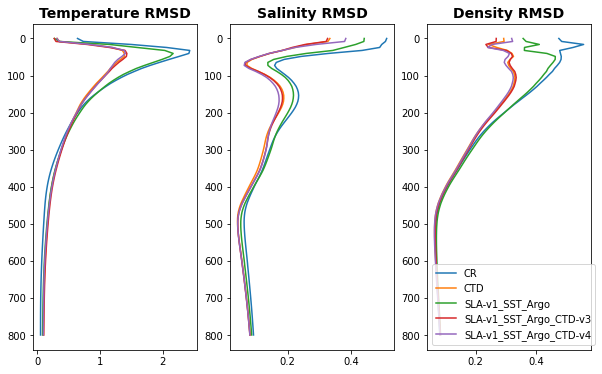

In [19]:
fig_rmsd_prof = plt.figure(figsize=(10,6))
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

for exp in experiments:
    
    ax1.plot(mse_temp_prof[exp], z_interp, label=exp)
#     ax1.set_ylim((0,200))
#     ax1.set_xlim((0,0.8))
    ax1.invert_yaxis()
    ax1.set_title('Temperature RMSD', fontsize=14, fontweight='bold')
    
    
    ax2.plot(mse_salt_prof[exp], z_interp, label=exp)
#     ax2.set_ylim((0, 200))
    ax2.invert_yaxis()
#     ax2.legend()
    ax2.set_title('Salinity RMSD', fontsize=14, fontweight='bold')
    
    ax3.plot(mse_dens_prof[exp], z_interp, label=exp)
#     ax3.set_ylim((0, 200))
    ax3.invert_yaxis()
    ax3.legend(loc=3)
    ax3.set_title('Density RMSD', fontsize=14, fontweight='bold')
        
plt.show()

In [294]:
fig_rmsd_prof.savefig('/home/jhernandez/Escritorio/Plots_validation_OSSE_pre-SWOT/profile_rmsd_temp_salinity_density.png', 
            dpi=250, transparent=False, facecolor="w")

**Plot BIAS**

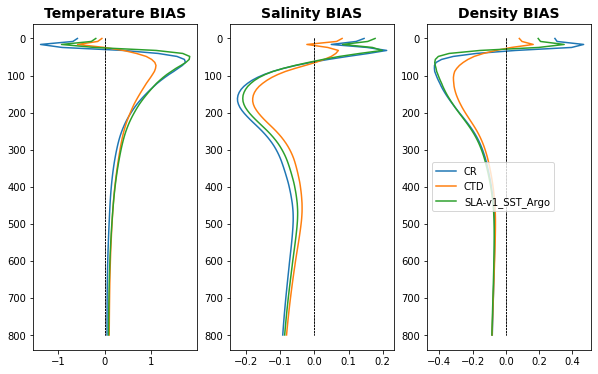

In [20]:
fig_bias_prof = plt.figure(figsize=(10,6))
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

for exp in ['CR','CTD','SLA-v1_SST_Argo']:#experiments:

    ax1.plot(bias_temp_prof[exp], z_interp, label=exp)
    ax1.plot(bias_dens_prof[exp]*0, z_interp,'k--', linewidth=0.6 )
    #ax1.set_ylim((0, 200))
    ax1.invert_yaxis()
    ax1.set_title('Temperature BIAS', fontsize=14, fontweight='bold')
    
    
    ax2.plot(bias_salt_prof[exp], z_interp, label=exp)
    ax2.plot(bias_dens_prof[exp]*0, z_interp,'k--', linewidth=0.6 )
    #ax2.set_ylim((0, 200))
    ax2.invert_yaxis()
    #ax2.legend()
    ax2.set_title('Salinity BIAS', fontsize=14, fontweight='bold')
    
    ax3.plot(bias_dens_prof[exp], z_interp, label=exp)
    ax3.plot(bias_dens_prof[exp]*0, z_interp,'k--', linewidth=0.6 )
    #ax3.set_ylim((0, 200))
    ax3.invert_yaxis()
    ax3.legend(loc=6)
    ax3.set_title('Density BIAS', fontsize=14, fontweight='bold')
        
        
plt.show()

In [296]:
fig_bias_prof.savefig('/home/jhernandez/Escritorio/Plots_validation_OSSE_pre-SWOT/profile_bias_temp_salinity_density.png', 
            dpi=250, transparent=False, facecolor="w")

Text(0.5, 1.0, 'NR Dens std ')

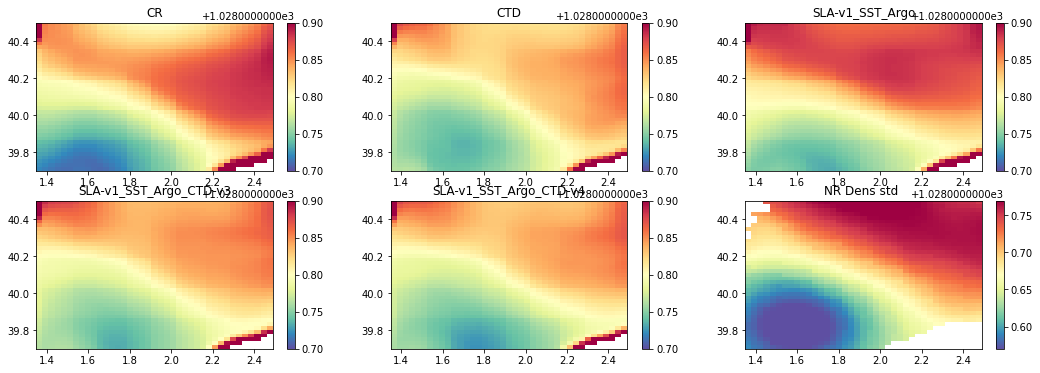

In [46]:
vmin, vmax= 1028.7, 1028.9

plt.figure(figsize=(18,6))
for i, exp in enumerate(experiments):
    plt.subplot(2,3,i+1)
    plt.pcolormesh(lons_interp, lats_interp, np.sum(d_interp[exp], axis=0)/100,
                   vmin=vmin, vmax=vmax, cmap='Spectral_r')
    plt.colorbar()
    plt.title(F"{exp}")

plt.subplot(2,3,6)
plt.pcolormesh(lons_interp, lats_interp, np.sum(d_interp['NR'], axis=0)/100,
               vmin=vmin-0.13, vmax=vmax-0.13, cmap='Spectral_r')
plt.colorbar()
plt.title(F"NR Dens std ")

In [446]:
plt.figure(figsize=(18,6))
for i, exp in enumerate(experiments):
    plt.subplot(2,3,i+1)
#     plt.pcolormesh(lons_interp, lats_interp, np.sqrt(np.mean((d_interp[exp] - d_interp['NR'])**2, axis=0)), vmin=0.1,vmax=0.3)
    plt.pcolormesh(lons_interp, lats_interp, np.sum((d_interp[exp] - d_interp['NR']), axis=0),
                   vmin=0.1,vmax=0.3)
    plt.colorbar()
    plt.title(F"{exp}")

plt.subplot(2,3,6)
plt.pcolormesh(lons_interp, lats_interp, np.mean(d_interp['NR'], axis=0), vmin=1030.4, vmax=1030.8)
plt.colorbar()
plt.title(F"NR")

Text(0.5, 1.0, 'NR')

## RMSD Dataframe

In [40]:
pd.options.display.float_format = "{:,.2f}".format

In [42]:
# RMSD Dataframe
df_rmsd = pd.DataFrame(data=[mse_temp, mse_salt, mse_dens], index=['Temp','Salt', 'Dens']).T
df_rmsd = df_rmsd.rename(index={'SLA-v1_SST_Argo': 'SLA+SST+Argo', 
                      'SLA-v1_SST_Argo_CTD-v3': 'SLA+SST+Argo+CTD', 
                      'SLA-v1_SST_Argo_CTD-v4': 'SLA+SST+Argo+CTD (z>15)'})

df_rmsd_norm = df_rmsd.copy(deep=True)
df_rmsd_norm['Temp'] = df_rmsd_norm['Temp'] / df_rmsd['Temp'].loc['CR']
df_rmsd_norm['Salt'] = df_rmsd_norm['Salt'] / df_rmsd['Salt'].loc['CR']
df_rmsd_norm['Dens'] = df_rmsd_norm['Dens'] / df_rmsd['Dens'].loc['CR']


# BIAS Dataframe
df_bias = pd.DataFrame(data=[bias_temp, bias_salt, bias_dens], index=['Temp','Salt', 'Dens']).T
df_bias = df_rmsd.rename(index={'SLA-v1_SST_Argo': 'SLA+SST+Argo', 
                      'SLA-v1_SST_Argo_CTD-v3': 'SLA+SST+Argo+CTD', 
                      'SLA-v1_SST_Argo_CTD-v4': 'SLA+SST+Argo+CTD (z>15)'})

# Temp (RMSD, BIAS, Corr) Dataframe
df_temp = pd.DataFrame(data=[mse_temp, bias_temp, ccoef_temp], index=['RMSD','BIAS', 'Corr']).T
df_temp = df_temp.rename(index={'SLA-v1_SST_Argo': 'SLA+SST+Argo', 
                      'SLA-v1_SST_Argo_CTD-v3': 'SLA+SST+Argo+CTD', 
                      'SLA-v1_SST_Argo_CTD-v4': 'SLA+SST+Argo+CTD (z>15)'})

# Salt (RMSD, BIAS, Corr) Dataframe
df_salt = pd.DataFrame(data=[mse_salt, bias_salt, ccoef_salt], index=['RMSD','BIAS', 'Corr']).T
df_salt = df_salt.rename(index={'SLA-v1_SST_Argo': 'SLA+SST+Argo', 
                      'SLA-v1_SST_Argo_CTD-v3': 'SLA+SST+Argo+CTD', 
                      'SLA-v1_SST_Argo_CTD-v4': 'SLA+SST+Argo+CTD (z>15)'})

# Dens (RMSD, BIAS, Corr) Dataframe
df_dens = pd.DataFrame(data=[mse_dens, bias_dens, ccoef_dens], index=['RMSD','BIAS', 'Corr']).T
df_dens = df_dens.rename(index={'SLA-v1_SST_Argo': 'SLA+SST+Argo', 
                      'SLA-v1_SST_Argo_CTD-v3': 'SLA+SST+Argo+CTD', 
                      'SLA-v1_SST_Argo_CTD-v4': 'SLA+SST+Argo+CTD (z>15)'})
df_rmsd 
df_temp['cRMSD'] = np.sqrt( df_temp['RMSD']**2 - df_temp['BIAS']**2)
df_salt['cRMSD'] = np.sqrt( df_salt['RMSD']**2 - df_salt['BIAS']**2)
df_dens['cRMSD'] = np.sqrt( df_dens['RMSD']**2 - df_dens['BIAS']**2)



**Temperature Metrics**

In [43]:
df_temp

RMSD  BIAS  Corr  cRMSD
CR                       0.78  0.31  0.97   0.71
CTD                      0.56  0.32  0.99   0.45
SLA+SST+Argo             0.72  0.40  0.97   0.61
SLA+SST+Argo+CTD         0.57  0.35  0.99   0.45
SLA+SST+Argo+CTD (z>15)  0.56  0.34  0.99   0.44

**Salinity Metrics**

In [44]:
df_salt

RMSD  BIAS  Corr  cRMSD
CR                       0.18 -0.09  0.84   0.15
CTD                      0.12 -0.07  0.91   0.10
SLA+SST+Argo             0.16 -0.08  0.86   0.14
SLA+SST+Argo+CTD         0.12 -0.07  0.91   0.10
SLA+SST+Argo+CTD (z>15)  0.12 -0.06  0.90   0.11

**Density Metrics**

In [45]:
df_dens

RMSD  BIAS  Corr  cRMSD
CR                       0.25 -0.13  0.97   0.21
CTD                      0.19 -0.12  0.99   0.14
SLA+SST+Argo             0.23 -0.15  0.98   0.18
SLA+SST+Argo+CTD         0.19 -0.13  0.99   0.14
SLA+SST+Argo+CTD (z>15)  0.18 -0.12  0.99   0.14

Text(0.5, 1.0, 'Normalized RMSD against NR TS fields')

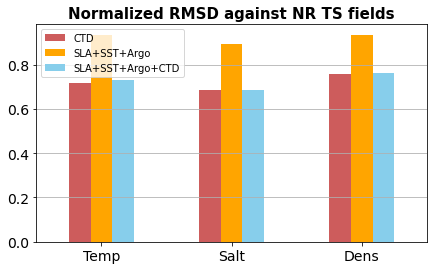

In [661]:
# Barplot of RMSD
ax = df_rmsd_norm.T[['CTD', 'SLA+SST+Argo', 'SLA+SST+Argo+CTD']].plot.bar(rot=0, figsize=(7,4),  color=['indianred','orange','skyblue'], fontsize=14)
fig = ax.get_figure()
ax.grid(axis='y')
ax.set_title('Normalized RMSD against NR TS fields', fontsize=15, fontweight='bold')

In [369]:
import os

plot_path = '/home/jhernandez/Escritorio/Plots_validation_OSSE_pre-SWOT/'
if os.path.exists(plot_path) == False:
    os.mkdir(plot_path)
    
fig.savefig(F"{plot_path}/rmsd_temperature-salinity-density_fields_swot_region.png", 
            dpi=250, transparent=False, facecolor="w")

In [187]:
df_rmsd_norm.T[['CTD', 'SLA+SST+Argo', 'SLA+SST+Argo+CTD']]

CTD  SLA+SST+Argo  SLA+SST+Argo+CTD
Temp 0.72          0.94              0.73
Salt 0.69          0.90              0.69
Dens 0.76          0.94              0.77

In [370]:
df_rmsd

Temp  Salt  Dens
CR                       0.78  0.18  0.25
CTD                      0.56  0.12  0.19
SLA+SST+Argo             0.73  0.16  0.23
SLA+SST+Argo+CTD         0.57  0.12  0.19
SLA+SST+Argo+CTD (z>15)  0.56  0.12  0.19

## Dynamic Height using gridded TS fields

In [388]:
ccoef_dh = [];bias_dh = []; rmsd_dh = []

for i, obs_label in enumerate(list(t_interp.keys())[:-1]):
    
    dh1 =  sw.gpan(s_interp['NR'], t_interp['NR'], z_matrix)[-1,:,:].flatten() / 10
    dh2 =  sw.gpan(s_interp[obs_label], t_interp[obs_label], z_matrix)[-1,:,:].flatten() / 10
    
    ii = ~np.isnan(dh1) & ~np.isnan(dh2)
    
    ccoef_dh.append( np.corrcoef( dh1[ii], dh2[ii] )[0][1] )
    bias_dh.append( np.mean(dh1[ii]) - np.mean(dh2[ii]) )
    rmsd_dh.append( np.sqrt( np.mean((dh1[ii] - dh2[ii])**2) ) )

# Temp (RMSD, BIAS, Corr) Dataframe
df_dh = pd.DataFrame(data={'RMSD': rmsd_dh, 'BIAS': bias_dh, 'Corr': ccoef_dh}, index=list(t_interp.keys())[:-1]).T
df_dh = df_dh.T.rename(index={'SLA-v1_SST_Argo': 'SLA+SST+Argo', 
                      'SLA-v1_SST_Argo_CTD-v3': 'SLA+SST+Argo+CTD', 
                      'SLA-v1_SST_Argo_CTD-v4': 'SLA+SST+Argo+CTD (z>15)'})
df_dh['cRMSD'] = np.sqrt( df_dh['RMSD']**2 - df_dh['BIAS']**2 )
df_dh['n-RMSD'] = df_dh['RMSD'] / df_dh['RMSD'].loc['CR']
df_dh['n-cRMSD'] = df_dh['cRMSD'] / df_dh['cRMSD'].loc['CR']
df_dh

RMSD  BIAS  Corr  cRMSD  n-RMSD  n-cRMSD
CR                       0.11  0.10  0.85   0.03    1.00     1.00
CTD                      0.10  0.09  0.93   0.03    0.92     0.98
SLA+SST+Argo             0.11  0.11  0.95   0.02    1.08     0.76
SLA+SST+Argo+CTD         0.10  0.10  0.96   0.03    0.95     0.90
SLA+SST+Argo+CTD (z>15)  0.10  0.09  0.95   0.03    0.91     0.90

In [390]:
fig_dh_an = plt.figure(figsize=(16,9))

vmin, vmax = -0.5, -0.38

for i, obs_label in enumerate(t_interp.keys()):

#     ds_da = xr.open_dataset(glob(F"{path_an}/ensmean_std/*ensmean_analysis_{obs_labels[i]}_un*nc")[0])
#     dheight = dinamic_height(ds_da, grd, limits = limits)
    dh =  sw.gpan(s_interp[obs_label], t_interp[obs_label], z_matrix)[-1,:,:] / 10
    
    # DA WMOP
    ax, gl = tools.make_map(subplot_dim=(2,3,i+1), fsize=14, limits=limits)
    plt.pcolormesh( lons_interp, lats_interp, dh, cmap='Spectral_r',
                   transform=gl.crs, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title(F"WMOP ANALYSIS DH\n {obs_label} {date.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')

ax, gl = tools.make_map(subplot_dim=(2,3,i+1), fsize=14, limits=limits)
plt.pcolormesh( lons_interp, lats_interp, dh, cmap='Spectral_r',
               transform=gl.crs, vmin=vmin+0.1, vmax=vmax+0.1)
plt.colorbar()
plt.title(F"WMOP ANALYSIS DH\n {obs_label} {date.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')



plt.show()

In [193]:
fig_dh_an.savefig(F"{plot_path}/dinamic_height_fields_swot_region.png", 
            dpi=250, transparent=False, facecolor="w")

**Differences between NR and Experients Dynamic Height**

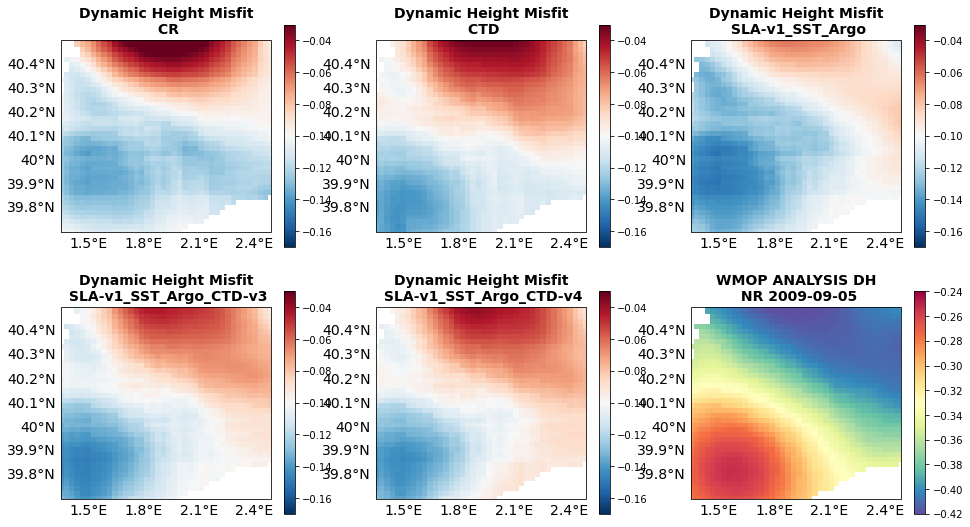

In [47]:
fig_dh_anomaly = plt.figure(figsize=(16,9))

vmin, vmax =  -0.17, -0.03

for i, obs_label in enumerate(t_interp.keys()):

#     ds_da = xr.open_dataset(glob(F"{path_an}/ensmean_std/*ensmean_analysis_{obs_labels[i]}_un*nc")[0])
#     dheight = dinamic_height(ds_da, grd, limits = limits)
    dh =  sw.gpan(s_interp[obs_label], t_interp[obs_label], z_matrix)[-1,:,:] / 10
    dh_nr =  sw.gpan(s_interp['NR'], t_interp['NR'], z_matrix)[-1,:,:] / 10
    
    # DA WMOP
    ax, gl = tools.make_map(subplot_dim=(2,3,i+1), fsize=14, limits=limits)
    plt.pcolormesh( lons_interp, lats_interp, dh - dh_nr , cmap='RdBu_r',
                   transform=gl.crs, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title(F"Dynamic Height Misfit\n {obs_label}", fontsize=14, fontweight='bold')

ax, gl = tools.make_map(subplot_dim=(2,3,i+1), fsize=14, limits=limits)
plt.pcolormesh( lons_interp, lats_interp, dh, cmap='Spectral_r',
               transform=gl.crs, vmin=-0.42, vmax=-0.24)
plt.colorbar()
plt.title(F"WMOP ANALYSIS DH\n {obs_label} {date.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')



plt.show()

In [730]:
fig_dh_anomaly.savefig(F"{plot_path}/dinamic_height_anomaly_swot_region.png", 
            dpi=250, transparent=False, facecolor="w")

**Difference Density Fields**

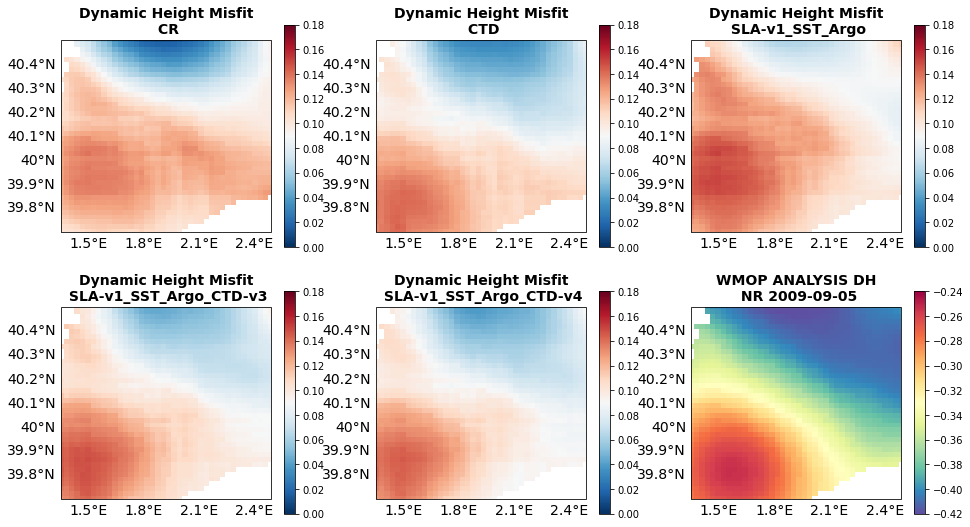

In [50]:
fig_dh_anomaly = plt.figure(figsize=(16,9))

vmin, vmax =  0, 0.18

for i, obs_label in enumerate(t_interp.keys()):

#     ds_da = xr.open_dataset(glob(F"{path_an}/ensmean_std/*ensmean_analysis_{obs_labels[i]}_un*nc")[0])
#     dheight = dinamic_height(ds_da, grd, limits = limits)
    dh =  sw.gpan(s_interp[obs_label], t_interp[obs_label], z_matrix)[-1,:,:] / 10
    dh_nr =  sw.gpan(s_interp['NR'], t_interp['NR'], z_matrix)[-1,:,:] / 10
    
    # DA WMOP
    ax, gl = tools.make_map(subplot_dim=(2,3,i+1), fsize=14, limits=limits)
    plt.pcolormesh( lons_interp, lats_interp, np.sqrt((dh - dh_nr )**2) , cmap='RdBu_r',
                   transform=gl.crs, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title(F"Dynamic Height Misfit\n {obs_label}", fontsize=14, fontweight='bold')

ax, gl = tools.make_map(subplot_dim=(2,3,i+1), fsize=14, limits=limits)
plt.pcolormesh( lons_interp, lats_interp, dh, cmap='Spectral_r',
               transform=gl.crs, vmin=-0.42, vmax=-0.24)
plt.colorbar()
plt.title(F"WMOP ANALYSIS DH\n {obs_label} {date.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')



plt.show()

**Salinity differences**

Text(0.5, 1.0, 'NR')

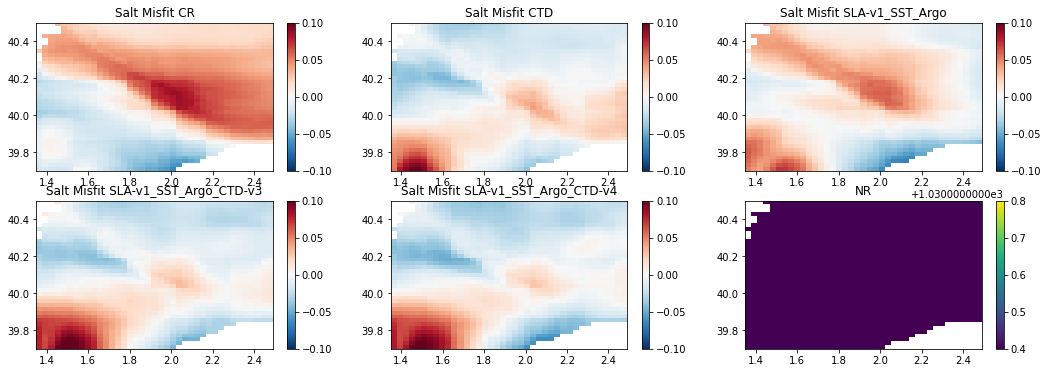

In [723]:
vmin, vmax = -0.1, 0.1
plt.figure(figsize=(18,6))
for i, exp in enumerate(experiments):
    plt.subplot(2,3,i+1)
#     plt.pcolormesh(lons_interp, lats_interp, np.sqrt(np.mean((d_interp[exp] - d_interp['NR'])**2, axis=0)), vmin=0.1,vmax=0.3)
    plt.pcolormesh(lons_interp, lats_interp, np.mean((s_interp[exp] - s_interp['NR']) - 0.07, axis=0), 
                   vmin=vmin, vmax=vmax, cmap='RdBu_r')
    plt.colorbar()
    plt.title(F"Salt Misfit {exp}")

plt.subplot(2,3,6)
plt.pcolormesh(lons_interp, lats_interp, np.mean(d_interp['NR'], axis=0), vmin=1030.4, vmax=1030.8)
plt.colorbar()
plt.title(F"NR")

Text(0.5, 1.0, 'NR')

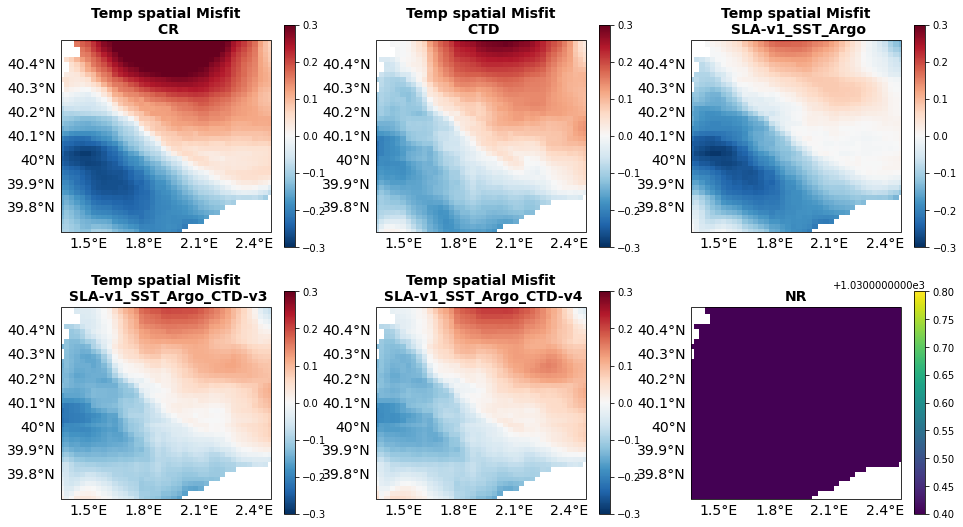

In [739]:
vmin, vmax = -0.3, 0.3
fig_temp_anomaly = plt.figure(figsize=(16,9))
for i, exp in enumerate(experiments):
#     plt.subplot(2,3,i+1)
#     plt.pcolormesh(lons_interp, lats_interp, np.sqrt(np.mean((d_interp[exp] - d_interp['NR'])**2, axis=0)), vmin=0.1,vmax=0.3)
    ax, gl = tools.make_map(subplot_dim=(2,3,i+1), fsize=14, limits=limits)
    plt.pcolormesh(lons_interp, lats_interp, np.mean((t_interp[exp] - t_interp['NR'] + 0.32) , axis=0),
                   vmin=vmin, vmax=vmax, cmap='RdBu_r', transform=gl.crs)
    plt.colorbar()
    plt.title(F"Temp spatial Misfit\n {exp}", fontsize=14, fontweight='bold')

# plt.subplot(2,3,6)
ax, gl = tools.make_map(subplot_dim=(2,3,6), fsize=14, limits=limits)
plt.pcolormesh(lons_interp, lats_interp, np.mean(d_interp['NR'], axis=0),
               vmin=1030.4, vmax=1030.8, transform=gl.crs)
plt.colorbar()
plt.title(F"NR", fontsize=14, fontweight='bold')

In [727]:
fig_temp_anomaly.savefig(F"{plot_path}/temperature_spatial_misfit_swot_region.png", 
            dpi=250, transparent=False, facecolor="w")

**Temp Spatial RMSD**

Text(0.5, 1.0, 'NR')

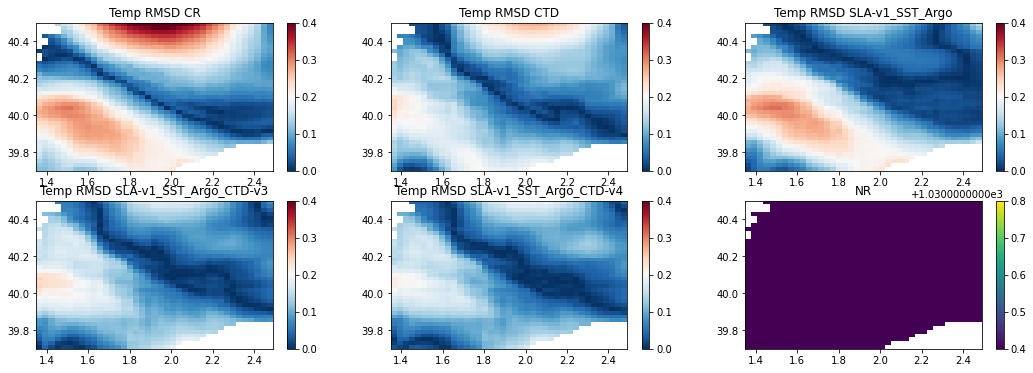

In [744]:
vmin, vmax = 0, 0.4
plt.figure(figsize=(18,6))
for i, exp in enumerate(experiments):
    plt.subplot(2,3,i+1)
#     plt.pcolormesh(lons_interp, lats_interp, np.sqrt(np.mean((d_interp[exp] - d_interp['NR'])**2, axis=0)), vmin=0.1,vmax=0.3)
    plt.pcolormesh(lons_interp, lats_interp, np.sqrt(np.mean((t_interp[exp] - t_interp['NR'] + 0.3) , axis=0)**2),
                   vmin=vmin, vmax=vmax, cmap='RdBu_r')
    plt.colorbar()
    plt.title(F"Temp RMSD {exp}")

plt.subplot(2,3,6)
plt.pcolormesh(lons_interp, lats_interp, np.mean(d_interp['NR'], axis=0), vmin=1030.4, vmax=1030.8)
plt.colorbar()
plt.title(F"NR")

In [718]:
for i, exp in enumerate(experiments):
    print(exp)
    print(np.mean((t_interp[exp][:,35:,30:] - t_interp['NR'][:,35:,30:]) ))


CR
-0.13549879713622023
CTD
-0.17544816552559056
SLA-v1_SST_Argo
-0.3543764352245863
SLA-v1_SST_Argo_CTD-v3
-0.2761739432070747
SLA-v1_SST_Argo_CTD-v4
-0.24700532659230234


CR
0.17778602123663464
-0.06247600451209492
0.16644704325207402
CTD
0.11971885537865469
-0.058256485798401585
0.10458865232708503
SLA-v1_SST_Argo
0.16021889604062858
-0.10367308374408567
0.12215558258004236
SLA-v1_SST_Argo_CTD-v3
0.11163512113223102
-0.07654695542482487
0.0812586234525159
SLA-v1_SST_Argo_CTD-v4
0.11265350374220605
-0.06880251715040704
0.08920216106778567


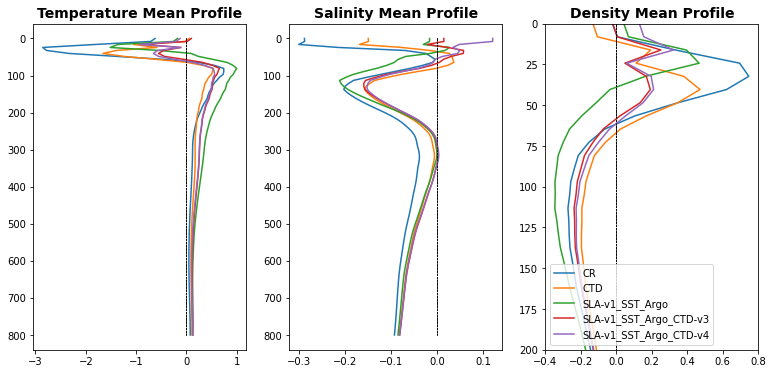

In [698]:
fig_prof = plt.figure(figsize=(13,6))
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)


for exp in experiments:
    
    ax1.plot(np.nanmean(np.nanmean( (t_interp['NR'][:,35:,25:35] -  t_interp[exp][:,35:,25:35]), axis=1), axis=1), z_interp, label=exp)
#     ax1.set_ylim((0,200))
#     ax1.set_xlim((0,0.8))
    ax1.plot(z_interp*0, z_interp, 'k--', linewidth=0.6)
    ax1.invert_yaxis()
    ax1.set_title('Temperature Mean Profile', fontsize=14, fontweight='bold')
    
    
    ax2.plot(np.nanmean(np.nanmean((s_interp['NR'][:,35:,25:35] - s_interp[exp][:,35:,25:35]), axis=1), axis=1), z_interp, label=exp)
#     ax2.set_ylim((0, 200))
    ax2.plot(z_interp*0, z_interp, 'k--', linewidth=0.6)
    ax2.invert_yaxis()
#     ax2.legend()
    ax2.set_title('Salinity Mean Profile', fontsize=14, fontweight='bold')
    
    ax3.plot(np.nanmean(np.nanmean((d_interp['NR'][:,35:,25:35] - d_interp[exp][:,35:,25:35]), axis=1), axis=1), z_interp, label=exp)
    ax3.plot(z_interp*0, z_interp, 'k--', linewidth=0.6)
    ax3.set_ylim((0, 200))
    ax3.invert_yaxis()
    ax3.legend(loc=3)
    ax3.set_title('Density Mean Profile', fontsize=14, fontweight='bold')
    
    biase = np.nanmean((d_interp['NR'][:,35:,25:35] - d_interp[exp][:,35:,25:35]))
    rmsee = np.sqrt(np.nanmean((d_interp['NR'][:,35:,25:35] - d_interp[exp][:,35:,25:35])**2))
    print(exp)
    print(rmsee)
    print(biase)
    print(np.sqrt(rmsee**2 - biase**2))

plt.show()

CR
0.2856345126724057
-0.15979416214555137
0.23675493780236964
CTD
0.23212082061528164
-0.17682236458717807
0.15037927631462666
SLA-v1_SST_Argo
0.25598388055405563
-0.17876366780189074
0.18322472043239219
SLA-v1_SST_Argo_CTD-v3
0.23217120570895564
-0.1812892513100087
0.14504370417155893
SLA-v1_SST_Argo_CTD-v4
0.23106247703929678
-0.17528777907237053
0.15054588271823102


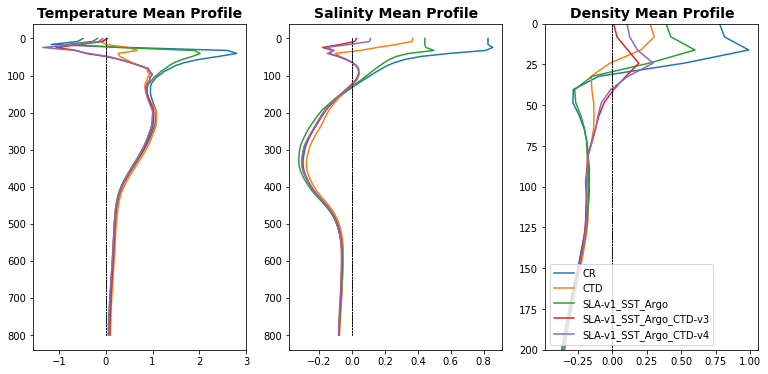

In [705]:
fig_prof = plt.figure(figsize=(13,6))
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)


for exp in experiments:
    
    ax1.plot(np.nanmean( (t_interp['NR'][:,5,5:15] -  t_interp[exp][:,5,5:15]), axis=1), z_interp, label=exp)
#     ax1.set_ylim((0,200))
#     ax1.set_xlim((0,0.8))
    ax1.plot(z_interp*0, z_interp, 'k--', linewidth=0.6)
    ax1.invert_yaxis()
    ax1.set_title('Temperature Mean Profile', fontsize=14, fontweight='bold')
    
    
    ax2.plot(np.nanmean((s_interp['NR'][:,5,5:15] - s_interp[exp][:,5,5:15]), axis=1), z_interp, label=exp)
#     ax2.set_ylim((0, 200))
    ax2.plot(z_interp*0, z_interp, 'k--', linewidth=0.6)
    ax2.invert_yaxis()
#     ax2.legend()
    ax2.set_title('Salinity Mean Profile', fontsize=14, fontweight='bold')
    
    ax3.plot(np.nanmean((d_interp['NR'][:,5,5:15] - d_interp[exp][:,5,5:15]), axis=1), z_interp, label=exp)
    ax3.plot(z_interp*0, z_interp, 'k--', linewidth=0.6)
    ax3.set_ylim((0, 200))
    ax3.invert_yaxis()
    ax3.legend(loc=3)
    ax3.set_title('Density Mean Profile', fontsize=14, fontweight='bold')
    
    biase = np.nanmean((d_interp['NR'][:,5,5:15] - d_interp[exp][:,5,5:15]))
    rmsee = np.sqrt(np.nanmean((d_interp['NR'][:,5,5:15] - d_interp[exp][:,5,5:15])**2))
    print(exp)
    print(rmsee)
    print(biase)
    print(np.sqrt(rmsee**2 - biase**2))

plt.show()

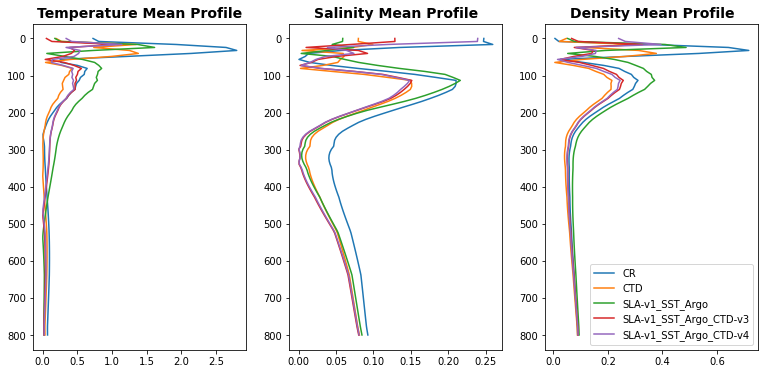

In [564]:
fig_prof = plt.figure(figsize=(13,6))
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)


for exp in experiments:
    
    ax1.plot(np.sqrt((t_interp['NR'][:,35,30] -  t_interp[exp][:,35,30] - 0.15)**2), z_interp, label=exp)
#     ax1.set_ylim((0,200))
#     ax1.set_xlim((0,0.8))
    ax1.invert_yaxis()
    ax1.set_title('Temperature Mean Profile', fontsize=14, fontweight='bold')
    
    
    ax2.plot(np.sqrt((s_interp['NR'][:,35,30] -  s_interp[exp][:,35,30])**2), z_interp, label=exp)
#     ax2.set_ylim((0, 200))
    ax2.invert_yaxis()
#     ax2.legend()
    ax2.set_title('Salinity Mean Profile', fontsize=14, fontweight='bold')
    
    ax3.plot(np.sqrt((d_interp['NR'][:,35,30] -  d_interp[exp][:,35,30])**2), z_interp, label=exp)
#     ax2.set_ylim((0, 200))
    ax3.invert_yaxis()
    ax3.legend()
    ax3.set_title('Density Mean Profile', fontsize=14, fontweight='bold')
    

plt.show()

In [548]:
(t_interp['NR'][:,35,30] -  t_interp[exp][:,35,30]).shape

(100,)

In [560]:
for exp in experiments:
    print(exp)
    print(F"\tTemp: {np.sqrt(np.nanmean((t_interp['NR'][:,35,30] -  t_interp[exp][:,35,30])**2) ):0.2f}" )
    print(F"\tSalt: {np.sqrt(np.nanmean((s_interp['NR'][:,35,30] -  s_interp[exp][:,35,30])**2)) :0.2f}" )
    print(F"\tDens: {np.sqrt(np.nanmean((d_interp['NR'][:,35,30] -  d_interp[exp][:,35,30])**2)):0.2f}"  )
    print()

CR
	Temp: 0.54
	Salt: 0.10
	Dens: 0.17

CTD
	Temp: 0.31
	Salt: 0.07
	Dens: 0.11

SLA-v1_SST_Argo
	Temp: 0.46
	Salt: 0.08
	Dens: 0.16

SLA-v1_SST_Argo_CTD-v3
	Temp: 0.30
	Salt: 0.07
	Dens: 0.11

SLA-v1_SST_Argo_CTD-v4
	Temp: 0.29
	Salt: 0.07
	Dens: 0.12



CR
Dens = -0.079
CTD
Dens = -0.089
SLA-v1_SST_Argo
Dens = -0.043
SLA-v1_SST_Argo_CTD-v3
Dens = -0.073
SLA-v1_SST_Argo_CTD-v4
Dens = -0.081


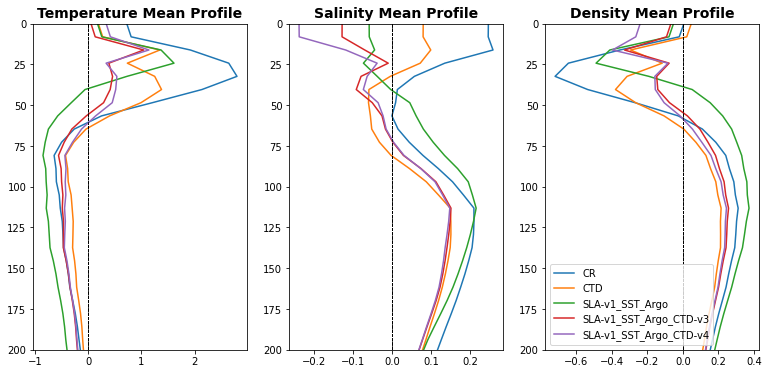

In [585]:
fig_prof = plt.figure(figsize=(13,6))
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

# ax1.plot(t_interp['NR'][:,35,30], z_interp, label='NR')
# ax2.plot(s_interp['NR'][:,35,30], z_interp, label='NR')
# ax3.plot(d_interp['NR'][:,35,30], z_interp, label='NR')
ky = 35
kx = 30

for exp in experiments:
    
    ax1.plot(t_interp[exp][:,ky,kx] - t_interp['NR'][:,ky,kx] +0.15 , z_interp, label=exp)
    ax1.set_ylim((0,200))
#     ax1.set_xlim((0,0.8))
    ax1.invert_yaxis()
    ax1.plot(z_interp*0, z_interp,'k--', linewidth=0.8)
    ax1.set_title('Temperature Mean Profile', fontsize=14, fontweight='bold')
    
    
    
    ax2.plot(s_interp[exp][:,ky,kx] - s_interp['NR'][:,ky,kx], z_interp, label=exp)
    ax2.set_ylim((0, 200))
    ax2.invert_yaxis()
    ax2.plot(z_interp*0, z_interp,'k--', linewidth=0.8)
#    ax2.legend()
    ax2.set_title('Salinity Mean Profile', fontsize=14, fontweight='bold')
    
    ax3.plot(d_interp[exp][:,ky,kx] - d_interp['NR'][:,ky,kx], z_interp, label=exp)
    ax3.plot(z_interp*0, z_interp,'k--', linewidth=0.8)
    ax3.set_ylim((0, 200))
    ax3.invert_yaxis()
    ax3.legend(loc=3)
    ax3.set_title('Density Mean Profile', fontsize=14, fontweight='bold')
    print(exp)
    print(F"Dens = {np.mean(d_interp[exp][:,ky,kx] - d_interp['NR'][:,ky,kx] - 0.15):0.3f}")

plt.show()

In [581]:
print(F"Temp = {np.mean(t_interp[exp][:,ky,kx] - t_interp['NR'][:,ky,kx] +0.15):0.2f}")

Temp = -0.03


CTD
Dens = -0.030
SLA-v1_SST_Argo
Dens = 0.004


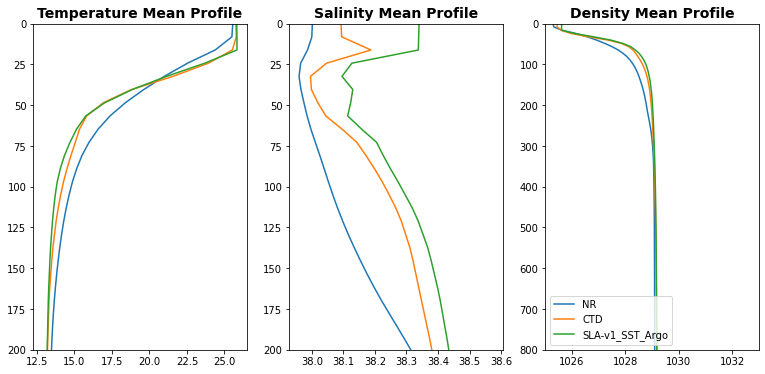

In [649]:
fig_prof = plt.figure(figsize=(13,6))
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

ax1.plot(t_interp['NR'][:,35,30], z_interp, label='NR')
ax2.plot(s_interp['NR'][:,35,30], z_interp, label='NR')
ax3.plot(sw.dens( s_interp['NR'][:,ky,kx], t_interp['NR'][:,ky,kx], t_interp['NR'][:,ky,kx]*0), z_interp, label='NR')
ky = 35
kx = 5

for exp in ['CTD','SLA-v1_SST_Argo']:
    
    ax1.plot(t_interp[exp][:,ky,kx] , z_interp, label=exp)
    ax1.set_ylim((0,200))
#     ax1.set_xlim((0,0.8))
    ax1.invert_yaxis()
#     ax1.plot(z_interp*0, z_interp,'k--', linewidth=0.8)
    ax1.set_title('Temperature Mean Profile', fontsize=14, fontweight='bold')
    
    
    
    ax2.plot(s_interp[exp][:,ky,kx], z_interp, label=exp)
    ax2.set_ylim((0, 200))
    ax2.invert_yaxis()
#     ax2.plot(z_interp*0, z_interp,'k--', linewidth=0.8)
#    ax2.legend()
    ax2.set_title('Salinity Mean Profile', fontsize=14, fontweight='bold')
    
    density = sw.dens( s_interp[exp][:,ky,kx], t_interp[exp][:,ky,kx], t_interp[exp][:,ky,kx]*0)
    ax3.plot(density , z_interp, label=exp)
#     ax3.plot(z_interp*0, z_interp,'k--', linewidth=0.8)
    ax3.set_ylim((0, 800))
    ax3.set_xlim((1025, 1033))
    ax3.invert_yaxis()
    ax3.legend(loc=3)
    ax3.set_title('Density Mean Profile', fontsize=14, fontweight='bold')
    print(exp)
    print(F"Dens = {np.mean(d_interp[exp][:,ky,kx] - d_interp['NR'][:,ky,kx] - 0.15):0.3f}")

plt.show()

In [647]:
help(sw.dens)

Help on function dens in module seawater.eos80:

dens(s, t, p)
    Density of Sea Water using UNESCO 1983 (EOS 80) polynomial.
    
    Parameters
    ----------
    s(p) : array_like
           salinity [psu (PSS-78)]
    t(p) : array_like
           temperature [℃ (ITS-90)]
    p : array_like
        pressure [db].
    
    Returns
    -------
    dens : array_like
           density  [kg m :sup:`3`]
    
    Examples
    --------
    >>> # Data from Unesco Tech. Paper in Marine Sci. No. 44, p22.
    >>> import seawater as sw
    >>> from seawater.library import T90conv
    >>> s = [0, 0, 0, 0, 35, 35, 35, 35]
    >>> t = T90conv([0, 0, 30, 30, 0, 0, 30, 30])
    >>> p = [0, 10000, 0, 10000, 0, 10000, 0, 10000]
    >>> sw.dens(s, t, p)
    array([  999.842594  ,  1045.33710972,   995.65113374,  1036.03148891,
            1028.10633141,  1070.95838408,  1021.72863949,  1060.55058771])
    
    References
    ----------
    .. [1] Fofonoff, P. and Millard, R.C. Jr UNESCO 1983. Algorith

In [630]:
ky = 35
kx = 22

dh_nr = sw.gpan(s_interp['NR'][:,ky,kx], t_interp['NR'][:,ky,kx], z_matrix[:,ky,kx])[-1] / 10

for exp in ['CR','SLA-v1_SST_Argo']:#experiments:
    
    dh_exp = sw.gpan(s_interp[exp][:,ky,kx], t_interp[exp][:,ky,kx], z_matrix[:,ky,kx])[-1] / 10
    print(exp)
    print(F"Dens = {np.mean(d_interp[exp][:,ky,kx] - d_interp['NR'][:,ky,kx]) - 0.15 :0.3f}")
    print(F"DH  = {dh_exp - dh_nr +0.1:0.3f}")

CR
Dens = -0.104
DH  = 0.065
SLA-v1_SST_Argo
Dens = -0.051
DH  = 0.025


In [629]:
ky = 25
kx = 3

dh_nr = sw.gpan(s_interp['NR'][:,ky,kx], t_interp['NR'][:,ky,kx], z_matrix[:,ky,kx])[-1] / 10

for exp in ['CR','SLA-v1_SST_Argo']:#experiments:
    
    dh_exp = sw.gpan(s_interp[exp][:,ky,kx], t_interp[exp][:,ky,kx], z_matrix[:,ky,kx])[-1] / 10
    print(exp)
    print(F"Dens = {np.mean(d_interp[exp][:,ky,kx] - d_interp['NR'][:,ky,kx]) - 0.15 :0.3f}")
    print(F"DH  = {dh_exp - dh_nr +0.1:0.3f}")

CR
Dens = -0.002
DH  = -0.015
SLA-v1_SST_Argo
Dens = 0.018
DH  = -0.029


Dens 
 CTD 0.128
Dens 
 SLA-v1_SST_Argo 0.150


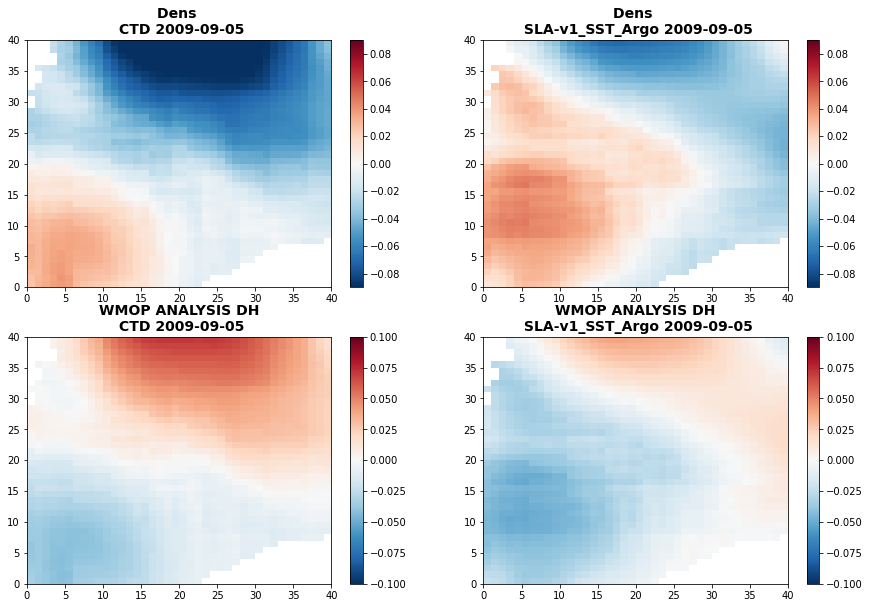

In [624]:
plt.figure(figsize=(15,10))

for i, obs_label in enumerate(['CTD','SLA-v1_SST_Argo']):

    plt.subplot(2,2,i+1)
    vmin, vmax =  -0.09, 0.09
    plt.pcolormesh(np.mean((d_interp[obs_label] - d_interp['NR']) - 0.15, axis=0),
               vmin=vmin, vmax=vmax, cmap='RdBu_r')
    plt.colorbar()
    plt.title(F"Dens \n {obs_label} {date.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')
    
    rr = np.sqrt(np.nanmean(np.mean((d_interp[obs_label] - d_interp['NR']) , axis=0)**2))
    print(F"Dens \n {obs_label} {rr:0.3f}")
#     ds_da = xr.open_dataset(glob(F"{path_an}/ensmean_std/*ensmean_analysis_{obs_labels[i]}_un*nc")[0])
#     dheight = dinamic_height(ds_da, grd, limits = limits)
    dh =  sw.gpan(s_interp[obs_label], t_interp[obs_label], z_matrix)[-1,:,:] / 10
    dh_nr =  sw.gpan(s_interp['NR'], t_interp['NR'], z_matrix)[-1,:,:] / 10
    
    plt.subplot(2,2,i+3)
    vmin, vmax =  -0.1, 0.1
    plt.pcolormesh( dh - dh_nr + 0.1, cmap='RdBu_r',  vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title(F"WMOP ANALYSIS DH\n {obs_label} {date.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')



In [ ]:
np.mean((d_interp[obs_label] - d_interp['NR']) - 0.15

CTD
Dens = -0.107
SLA-v1_SST_Argo
Dens = -0.064


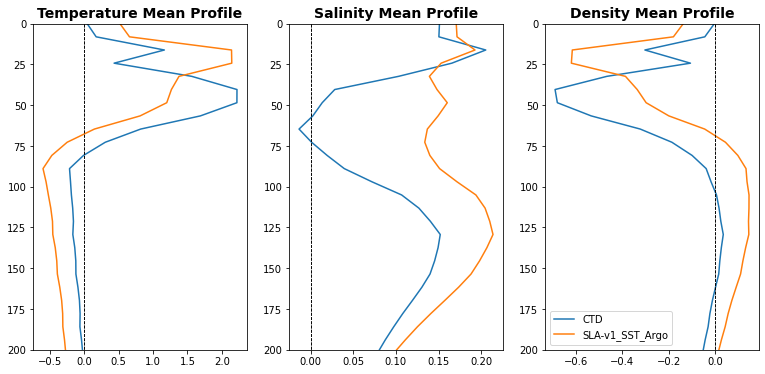

In [663]:
fig_prof = plt.figure(figsize=(13,6))
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

# ax1.plot(t_interp['NR'][:,35,30], z_interp, label='NR')
# ax2.plot(s_interp['NR'][:,35,30], z_interp, label='NR')
# ax3.plot(d_interp['NR'][:,35,30], z_interp, label='NR')
ky = 38
kx = 22

for exp in ['CTD','SLA-v1_SST_Argo']:
    
    ax1.plot(t_interp[exp][:,ky,kx] - t_interp['NR'][:,ky,kx] +0.15 , z_interp, label=exp)
    ax1.set_ylim((0,200))
#     ax1.set_xlim((0,0.8))
    ax1.invert_yaxis()
    ax1.plot(z_interp*0, z_interp,'k--', linewidth=0.8)
    ax1.set_title('Temperature Mean Profile', fontsize=14, fontweight='bold')
    
    
    
    ax2.plot(s_interp[exp][:,ky,kx] - s_interp['NR'][:,ky,kx], z_interp, label=exp)
    ax2.set_ylim((0, 200))
    ax2.invert_yaxis()
    ax2.plot(z_interp*0, z_interp,'k--', linewidth=0.8)
#    ax2.legend()
    ax2.set_title('Salinity Mean Profile', fontsize=14, fontweight='bold')
    
    ax3.plot(d_interp[exp][:,ky,kx] - d_interp['NR'][:,ky,kx] -0.15, z_interp, label=exp)
    ax3.plot(z_interp*0, z_interp,'k--', linewidth=0.8)
    ax3.set_ylim((0, 200))
    ax3.invert_yaxis()
    ax3.legend(loc=3)
    ax3.set_title('Density Mean Profile', fontsize=14, fontweight='bold')
    print(exp)
    print(F"Dens = {np.mean(d_interp[exp][:,ky,kx] - d_interp['NR'][:,ky,kx] - 0.15):0.3f}")

plt.show()

CTD
Dens = -0.025
SLA-v1_SST_Argo
Dens = 0.018


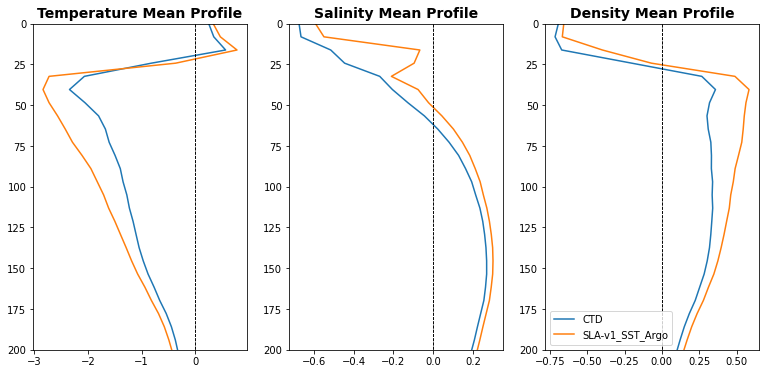

In [634]:
fig_prof = plt.figure(figsize=(13,6))
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

# ax1.plot(t_interp['NR'][:,35,30], z_interp, label='NR')
# ax2.plot(s_interp['NR'][:,35,30], z_interp, label='NR')
# ax3.plot(d_interp['NR'][:,35,30], z_interp, label='NR')
ky = 25
kx = 3

for exp in ['CTD','SLA-v1_SST_Argo']:
    
    ax1.plot(t_interp[exp][:,ky,kx] - t_interp['NR'][:,ky,kx] +0.15 , z_interp, label=exp)
    ax1.set_ylim((0,200))
#     ax1.set_xlim((0,0.8))
    ax1.invert_yaxis()
    ax1.plot(z_interp*0, z_interp,'k--', linewidth=0.8)
    ax1.set_title('Temperature Mean Profile', fontsize=14, fontweight='bold')
    
    
    
    ax2.plot(s_interp[exp][:,ky,kx] - s_interp['NR'][:,ky,kx], z_interp, label=exp)
    ax2.set_ylim((0, 200))
    ax2.invert_yaxis()
    ax2.plot(z_interp*0, z_interp,'k--', linewidth=0.8)
#    ax2.legend()
    ax2.set_title('Salinity Mean Profile', fontsize=14, fontweight='bold')
    
    ax3.plot(d_interp[exp][:,ky,kx] - d_interp['NR'][:,ky,kx] -0.15, z_interp, label=exp)
    ax3.plot(z_interp*0, z_interp,'k--', linewidth=0.8)
    ax3.set_ylim((0, 200))
    ax3.invert_yaxis()
    ax3.legend(loc=3)
    ax3.set_title('Density Mean Profile', fontsize=14, fontweight='bold')
    print(exp)
    print(F"Dens = {np.mean(d_interp[exp][:,ky,kx] - d_interp['NR'][:,ky,kx] - 0.15):0.3f}")

plt.show()